## Note: You need High RAM runtime to preprocess the STL dataset in memory! (default runtime may run out of memory and crash)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install kornia

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from os.path import join
import matplotlib.pylab as plt
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, utils

In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')

%cp /content/gdrive/MyDrive/bio_simCLR/stl10_binary.tar.gz /content/Dataset/stl10_binary.tar.gz 
%ls /content/gdrive/MyDrive/bio_simCLR
%ls /content/Dataset/

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
deepgaze_scanpath.py  stl10_unlabeled_salmaps_salicon.npy
scanpaths.tar.bz      stl10_unlabeled_scanpath_deepgaze.npy
stl10_binary.tar.gz
FastSal/             stl10_unlabeled_salmaps_salicon.npy
stl10_binary/        stl10_unlabeled_scanpath_deepgaze.npy
stl10_binary.tar.gz


In [5]:
# it took 2-5 mins to download the STL10 dataset
dataset = datasets.STL10("Dataset", split="unlabeled", download=True, transform=transforms.ToTensor(),)

Files already downloaded and verified


# Preprocess Dataset with Saliency Models

In [6]:
!git clone https://github.com/Animadversio/FastSal.git
%cd FastSal

fatal: destination path 'FastSal' already exists and is not an empty directory.
/content/FastSal


In [7]:
import model.fastSal as fastsal

%mv /content/FastSal/utils.py /content/FastSal/utils_fastsal.py 
# rename utils.py in fastsal to avoid calling utils.py in Foveated_Saccade_SimCLR
from utils_fastsal import load_weight

# /content/FastSal/model/ adaptation_layer.py upload my version (see code changes in Demo 1)
model = fastsal.fastsal(pretrain_mode=False, model_type='A')
state_dict, opt_state = load_weight("weights/salicon_A.pth", remove_decoder=False)
model.load_state_dict(state_dict)
model.cuda().eval();

mv: cannot stat '/content/FastSal/utils.py': No such file or directory


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
dataloader = DataLoader(dataset, batch_size=75, shuffle=False, drop_last=False)

%cd /content/Dataset
!gdown https://drive.google.com/uc?id=1cXp7Qg0O23lGyYnjS1a7oUCOY8hw3ckn # # ran generate_salmaps_dataset.py to get stl10_unlabeled_salmaps_salicon.npy to folder /content/Dataset

# !tar -zcvf /content/Dataset/stl10_unlabeled_salmaps_salicon.tar.gz /content/Dataset/stl10_unlabeled_salmaps_salicon.npy

salmap_arr = np.load('/content/Dataset/stl10_unlabeled_salmaps_salicon.npy')

/content/Dataset
Downloading...
From: https://drive.google.com/uc?id=1cXp7Qg0O23lGyYnjS1a7oUCOY8hw3ckn
To: /content/Dataset/stl10_unlabeled_salmaps_salicon.npy
100% 3.69G/3.69G [00:24<00:00, 149MB/s]


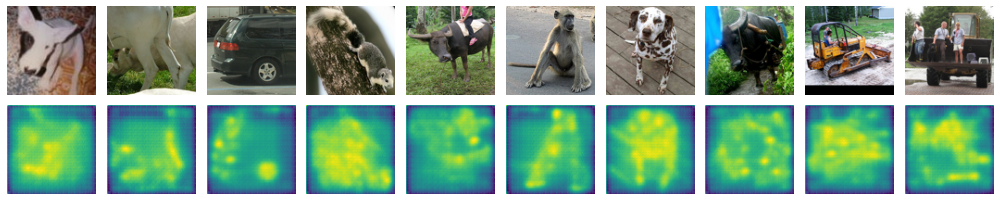

In [9]:
def visualize_salmap():
  figh, axs = plt.subplots(2, 10, figsize=(14, 3))
  for i in range(10):
    idx = np.random.randint(1E5)
    img, _ = dataset[idx]
    salmap = salmap_arr[idx,0,:,:]
    axs[0, i].imshow(img.permute([1,2,0]))
    axs[0, i].axis("off")
    axs[1, i].imshow(salmap)
    axs[1, i].axis("off")
  plt.tight_layout()
  plt.show()
  # figh.savefig("/content/example%03d.png"%np.random.randint(1E3))
visualize_salmap()

## Training SimCLR

In [10]:
%cd /content/
!git clone https://github.com/Animadversio/Foveated_Saccade_SimCLR.git
%cd /content/Foveated_Saccade_SimCLR
!git checkout dev

/content
fatal: destination path 'Foveated_Saccade_SimCLR' already exists and is not an empty directory.
/content/Foveated_Saccade_SimCLR
M	data_aug/cort_magnif_tfm.py
M	data_aug/dataset_w_salmap.py
M	data_aug/visualize_aug_dataset.py
M	simclr.py
Already on 'dev'
Your branch is up to date with 'origin/dev'.


In [11]:
# %load_ext tensorboard
# %tensorboard --logdir /content/Foveated_Saccade_SimCLR/runs

In [12]:
# load scanpath_arr

%cd /content/Dataset
!gdown https://drive.google.com/uc?id=1-2QtN-V8IYA5qGH5R1zbN53K3u2aOhPE
scanpath_arr = np.load('/content/Dataset/stl10_unlabeled_scanpath_deepgaze.npy')

# # migrated into class definition

# print(np.amax(scanpath_arr)) # scanpath prediction was done on 256 x 256 img
# scanpath_arr = np.floor(scanpath_arr / 255 * 95) # scale down
# print(np.amax(scanpath_arr)) # to match STL10 image 96 x 96 pixels

# plt.subplot(1,2,1)
# plt.imshow(scanpath_arr[88126, :, :])
# plt.colorbar();
# plt.subplot(1,2,2)
# plt.imshow(scanpath_arr[88127, :, :]);

/content/Dataset
Downloading...
From: https://drive.google.com/uc?id=1-2QtN-V8IYA5qGH5R1zbN53K3u2aOhPE
To: /content/Dataset/stl10_unlabeled_scanpath_deepgaze.npy
100% 32.0M/32.0M [00:00<00:00, 223MB/s]


In [32]:
# import time
# time.sleep(3600*10)

In [14]:
# /content/Foveated_Saccade_SimCLR/data_aug/
# /content/Foveated_Saccade_SimCLR/data_aug/visualize_aug_dataset.py
# /content/Foveated_Saccade_SimCLR/data_aug/dataset_w_salmap.py
# /content/Foveated_Saccade_SimCLR/data_aug/cort_magnif_tfm.py

# for i in range(len(train_loader)):
#     image, _ = train_loader[i] -> image, _ = train_loader[i, epoch_counter]

In [16]:
def views_by_epoch(i, epoch_idx):
    epoch_view_one = np.arange(0, 20-1 - (1-1)) # nfix = 20, step_diff = 1
    epoch_view_two = epoch_view_one + 1 # immediate neighbor fixation

    for step_diff in np.arange(2, 7+1): # start from skip neighbor fixation pairs
      # print(step_diff)
      tmp_one = np.arange(0, 20-1 - (step_diff-1))
      tmp_two = tmp_one + step_diff
      epoch_view_one = np.append(epoch_view_one, tmp_one)
      epoch_view_two = np.append(epoch_view_two, tmp_two)

    epoch_iview = np.vstack((epoch_view_one, epoch_view_two))
    epoch_iview.shape # n_views = 2, n_epoch = 100, 
    return epoch_iview[i, epoch_idx]

In [37]:
%cd /content/Foveated_Saccade_SimCLR/

from data_aug.dataset_w_salmap import Contrastive_STL10_w_CortMagnif, get_RandomMagnifTfm
dataset_dir = "/content/Dataset"
train_dataset = Contrastive_STL10_w_CortMagnif(dataset_dir=dataset_dir,
    transform=None, split="unlabeled", n_views=2,
    crop=False, magnif=True, sal_sample=False, memmap=True,\
    views_by_epoch=views_by_epoch)

/content/Foveated_Saccade_SimCLR
Files already downloaded and verified


In [25]:
train_dataset.set_epoch(99)

set current epoch to 99


<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


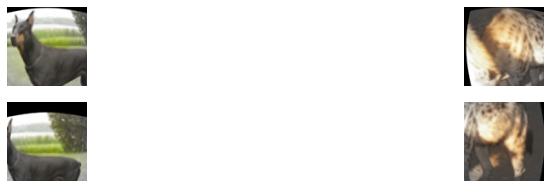

In [39]:
from data_aug.visualize_aug_dataset import visualize_samples
train_dataset.magnifier = get_RandomMagnifTfm(grid_generator="radial_quad_isotrop",
              bdr=16, fov=20, K=20, cover_ratio=0.3,
              sal_sample=True, sample_temperature=0.5,)
train_dataset.n_views = 2
idxs = [[16659, 0], [24019, 99]] #38327, 41148, 58469, 67493, 131, 58202, 66666, 65017]
_, idxs = visualize_samples(train_dataset, idxs)

In [127]:
# train_loader = torch.utils.data.DataLoader(
#     train_dataset, batch_size=256, shuffle=True,
#     num_workers=3, pin_memory=True, drop_last=True)

# for epoch_counter in range(2):
#     for i in tqdm(range(len(train_loader))):
#     # for images, _ in tqdm(train_loader): 
#         # Train loader have performed the augmentation; it returns a list of different augmented images. 
#         images, _ = train_loader[[i, epoch_counter]]
#         images = torch.cat(images, dim=0)

In [133]:
# help(train_loader.dataset.set_epoch)

Help on method set_epoch in module data_aug.dataset_w_salmap:

set_epoch(epoch_id) method of data_aug.dataset_w_salmap.Contrastive_STL10_w_CortMagnif instance



In [ ]:
!python run_magnif.py -data /content/Dataset -dataset-name stl10 \
    --workers 4 --log_root /content/Foveated_Saccade_SimCLR/runs  --randomize_seed \
    --ckpt_every_n_epocs 1 --epochs 100  --batch-size 16  --out_dim 256  \
    --run_label test  --magnif \
    --disable_blur  --cover_ratio 0.05 0.35  --fov_size 20 \
    --gridfunc_form radial_quad  --sample_temperature 1.5  --sampling_bdr 16 \
    --K 20  --temperature 0.07
#   --crop False  --sal_control False  --sal_sample False 

Namespace(K=20.0, arch='resnet18', batch_size=16, blur=False, ckpt_every_n_epocs=1, cover_ratio=[0.05, 0.35], crop=False, data='/content/Dataset', dataset_name='stl10', device=device(type='cuda'), disable_blur=True, disable_cuda=False, dry_run=False, epochs=100, fov_size=20.0, fp16_precision=False, gpu_index=0, gridfunc_form='radial_quad', log_every_n_steps=100, log_root='/content/Foveated_Saccade_SimCLR/runs', lr=0.0003, magnif=True, n_views=2, out_dim=256, randomize_seed=True, run_label='test', sal_control=False, sal_sample=False, sample_temperature=1.5, sampling_bdr=16, seed=None, slope_C=1.5, temperature=0.07, weight_decay=0.0001, workers=4)
Files already downloaded and verified
tcmalloc: large alloc 2764800000 bytes == 0x87a0000 @  0x7f05029f81e7 0x7f049226f0ce 0x7f04922c6e57 0x7f04922c7a6f 0x7f049236dc5d 0x593835 0x548c51 0x5127f1 0x549576 0x593fce 0x511e2c 0x549e0e 0x4bca8a 0x532b86 0x594a96 0x548cc1 0x5127f1 0x549576 0x4bca8a 0x532b86 0x594a96 0x548cc1 0x5127f1 0x593dd7 0x5118f

In [ ]:
# /usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py

In [ ]:
# !python run_magnif.py -data /content/Dataset -dataset-name stl10 \
#     --workers 16 --log_root /content/Foveated_Saccade_SimCLR/runs  --randomize_seed \
#     --ckpt_every_n_epocs 5 --epochs 100  --batch-size 256  --out_dim 256  \
#     --run_label test  --magnif \
#     --disable_blur  --cover_ratio 0.05 0.35  --fov_size 20 \
#     --gridfunc_form radial_quad  --sample_temperature 1.5  --sampling_bdr 16 \
#     --K 20  --temperature 0.07
# #   --crop False  --sal_control False  --sal_sample False 

In [ ]:
# # github repo readme main branch:
# !python run_magnif.py -data $Datasets_path -dataset-name stl10 \
#     --workers 16 --log_root $logdir \
#     --ckpt_every_n_epocs 5 --epochs 100  --batch-size 256  --out_dim 256  \
#     --run_label proj256_eval_magnif_cvr_0_05-0_35 --magnif \
#     --cover_ratio 0.05 0.35  --fov_size 20  --K  20  --sampling_bdr 16

In [136]:
# # demo 4 final script revised:
# !python run_magnif.py -data /content/Dataset -dataset-name stl10 \
#   --workers 3 --log_root /content/Foveated_Saccade_SimCLR/runs \
# 	--ckpt_every_n_epocs 5 --epochs 100  --batch-size 256  --out_dim 256 \
#   --run_label proj256_eval_magnif_bsl --crop &

In [ ]:
# # demo 4 final script:
# !python run_magnif.py -data /content/Dataset -dataset-name stl10 --workers 3 --log_root /content/Foveated_Saccade_SimCLR/runs \
# 	--ckpt_every_n_epocs 5 --epochs 100  --batch-size 256  --out_dim 256 \
#   --run_label proj256_eval_magnif_bsl --crop &

Namespace(K=20, arch='resnet18', batch_size=256, blur=True, ckpt_every_n_epocs=5, cover_ratio=(0.05, 0.7), crop=True, data='/content/Dataset', dataset_name='stl10', device=device(type='cuda'), disable_blur=False, disable_cuda=False, dry_run=False, epochs=100, fov_size=20, fp16_precision=False, gpu_index=0, gridfunc_form='radial_quad', log_every_n_steps=100, log_root='/content/Foveated_Saccade_SimCLR/runs', lr=0.0003, magnif=False, n_views=2, out_dim=256, randomize_seed=False, run_label='proj256_eval_magnif_bsl', sal_control=False, sal_sample=False, sample_temperature=1.5, sampling_bdr=16, seed=None, slope_C=1.5, temperature=0.07, weight_decay=0.0001, workers=3)
Files already downloaded and verified
tcmalloc: large alloc 2764800000 bytes == 0x7eda000 @  0x7fca973211e7 0x7fca26bd10ce 0x7fca26c28e57 0x7fca26c29a6f 0x7fca26ccfc5d 0x593835 0x548c51 0x5127f1 0x549576 0x593fce 0x511e2c 0x549e0e 0x4bca8a 0x532b86 0x594a96 0x548cc1 0x5127f1 0x549576 0x4bca8a 0x532b86 0x594a96 0x548cc1 0x5127f1 